In [26]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle

import linmix

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [27]:
#Load Data
summed_columns = QTable.read("Data/SUMMED_ION_COLUMNS.fits")


# CosDwarfs
cd_R, cd_Rvir = np.loadtxt("Data/CosDwarfs_Table1.txt", skiprows = 1, usecols = [7,8], unpack = True)
cd_NCIV_rows = np.loadtxt("Data/CosDwarfs_Table1.txt", skiprows = 1, usecols = [10], dtype = "str", delimiter = "\t")
cd_NCIV = np.array([row.split(" ")[0].split("<")[-1].split(">")[-1] for row in cd_NCIV_rows], dtype = np.float32)
cd_NCIV_err = np.zeros_like(cd_NCIV)

for ell,row in enumerate(cd_NCIV_rows):
    if len(row.split(" ")) == 3:
        cd_NCIV_err[ell] = float(row.split(" ")[-1])
        
    elif len(row.split("<"))==2:
        cd_NCIV_err[ell] = -1
        
    elif len(row.split(">"))==2:
        cd_NCIV_err[ell] = -5
        
cd_R_Rvir = cd_R/cd_Rvir

# Project Amiga
am_R, am_NCIV = np.loadtxt("Data/Amiga_Detections.csv", delimiter = ",", unpack = True)
am_R_ul, am_NCIV_ul = np.loadtxt("Data/Amiga_UpperLimits.csv", delimiter = ",", unpack = True)

In [28]:
am_R_phys = am_R * 230
am_R_phys_ul = am_R_ul * 230
am_R_vir = am_R_phys / 300
am_R_vir_ul = am_R_phys_ul / 300

In [29]:
am_R_vir


array([0.07849206, 0.10404762, 0.15880952, 0.1715873 , 0.19714286,
       0.25555556, 0.31214286, 0.43992063, 0.50380952, 0.70095238,
       0.77396825, 0.79769841, 0.9765873 , 1.0952381 , 1.14452381,
       1.24309524, 1.68301587, 1.77793651])

In [30]:
summed_columns

SOURCE,RHO_LMC,MEAN_CIV_V,LOG_N_OVI,LOG_N_ERR_OVI,LOG_N_CIV,LOG_N_ERR_CIV,LOG_N_SiIV,LOG_N_ERR_SiIV,LOG_N_CII,LOG_N_ERR_CII,LOG_N_SiII,LOG_N_ERR_SiII,LOG_N_SiIII,LOG_N_ERR_SiIII,LOG_N_AlII,LOG_N_ERR_AlII,LOG_N_FeII,LOG_N_ERR_FeII,LOG_N_OI,LOG_N_ERR_OI,GAL_LON,GAL_LAT
,kpc,,,,,,,,,,,,,,,,,,,,deg,deg
bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
PKS0637-75,6.6777271801538625,315.21209141225086,--,--,13.847500042416913,0.21486380232322203,13.023835640364153,0.5834980364754688,14.592223957303432,0.20825515522942822,14.423482925766141,0.05965410886436371,13.943778188150093,0.11270708941170897,13.04697716400103,0.10184503532865698,14.34355276410756,0.09105571480132185,15.120269343978967,0.1621508215075317,286.3683639918138,-27.158416955795435
HE0246-4101,28.825902516579085,--,--,--,12.981771111610092,-1.0,12.90625051328287,0.09087708138797361,14.454491193099607,0.0314211379546636,13.985330626860792,0.030371764799867952,13.872228473994195,0.5783835389656298,12.697159077902358,0.12130725843288087,13.95290739153146,0.15751291176463264,13.264662529903703,-1.0,250.16044154586777,-62.40148587222074
RBS144,28.589275460501888,181.12309569155778,13.874134462156777,0.10900524502448398,13.111985886935148,0.13628899426228863,12.19051614380182,-1.0,13.867881652947965,0.03906319793496885,12.728003183988772,0.03615444078856229,12.862999592175289,0.04087709294311042,11.655409049885188,-1.0,13.097197668583595,-1.0,13.748984570547393,-1.0,299.48369588633375,-65.83616648873654
PKS0552-640,5.548363813437074,361.99659836006555,14.390315012963955,-1.0,13.874675995667005,0.1846756233686016,12.451331517447395,0.18747038876643973,14.856101080776329,0.13473122594024226,14.232661082789123,0.07775236711870939,13.99398163764152,0.1514998958590301,13.212104181402346,0.1003447437663694,14.038385439196457,0.2253596788523948,14.699398372260832,0.11851215583123938,273.4655755409904,-30.611442195488028
PKS0202-76,13.323103840073875,275.8650137714024,--,--,13.445831605889019,0.21566071528656142,12.818391107782787,0.22672379738340956,14.814676037521908,0.6817968089522809,14.598577647820482,0.05350045542988317,14.174878848266244,0.2341701268572903,13.331226184956481,0.1235015766150336,14.424421417080833,0.1984660328967396,15.240034082557358,0.13499753644187712,297.54865746073773,-40.04515968380045
HE0003-5023,32.46658316833735,--,--,--,12.538038259787562,-1.0,12.073105125154955,-1.0,12.672290827079202,-1.0,11.257679148935926,-1.0,11.60977936887398,-1.0,11.678059820471963,-1.0,12.947329831446304,-1.0,--,--,320.7097875454362,-65.40537537289745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HE2336-5540,30.93240492300965,--,14.118326289010186,-1.0,12.709070030741062,-1.0,12.372347443650337,-1.0,12.873767209646072,-1.0,11.807213639072447,-1.0,11.829676261715681,-1.0,11.989687930329888,-1.0,13.089416279625663,-1.0,13.272305593426536,-1.0,322.8252451074142,-58.85345393202218


# Linear Regression

In [6]:
xx = np.linspace(0,50,1000)

In [7]:
#OI

OI_mask = np.isnan(summed_columns["LOG_N_OI"]) | np.isinf(summed_columns["LOG_N_OI"])

xOI = summed_columns["RHO_LMC"].value[~OI_mask]
yOI = summed_columns["LOG_N_OI"][~OI_mask]
xsig_OI = np.zeros_like(xOI)
ysig_OI = summed_columns["LOG_N_ERR_OI"][~OI_mask]
delta_OI = summed_columns["LOG_N_ERR_OI"][~OI_mask] > 0
lmcens_OI = linmix.LinMix(xOI, yOI, xsig_OI, ysig_OI, delta = delta_OI, K = 2)
lmcens_OI.run_mcmc(silent = True)

yints_OI = lmcens_OI.chain['alpha']
slopes_OI = lmcens_OI.chain['beta']

mean_yint_OI = yints_OI.mean()
mean_slope_OI = slopes_OI.mean()

all_lines_OI = np.array([m*xx + b for (m,b) in zip(slopes_OI, yints_OI)])
lo_line_OI, med_line_OI, hi_line_OI = np.percentile(all_lines_OI, (16,50,84), axis = 0)
mean_line_OI = mean_slope_OI*xx + mean_yint_OI




In [8]:
#SiII

SiII_mask = np.isnan(summed_columns["LOG_N_SiII"]) | np.isinf(summed_columns["LOG_N_SiII"])

xSiII = summed_columns["RHO_LMC"].value[~SiII_mask]
ySiII = summed_columns["LOG_N_SiII"][~SiII_mask]
xsig_SiII = np.zeros_like(xSiII)
ysig_SiII = summed_columns["LOG_N_ERR_SiII"][~SiII_mask]
delta_SiII = summed_columns["LOG_N_ERR_SiII"][~SiII_mask] > 0
lmcens_SiII = linmix.LinMix(xSiII, ySiII, xsig_SiII, ysig_SiII, delta = delta_SiII, K = 2)
lmcens_SiII.run_mcmc(silent = True)

yints_SiII = lmcens_SiII.chain['alpha']
slopes_SiII = lmcens_SiII.chain['beta']

mean_yint_SiII = yints_SiII.mean()
mean_slope_SiII = slopes_SiII.mean()

all_lines_SiII = np.array([m*xx + b for (m,b) in zip(slopes_SiII, yints_SiII)])
lo_line_SiII, med_line_SiII, hi_line_SiII = np.percentile(all_lines_SiII, (16,50,84), axis = 0)
mean_line_SiII = mean_slope_SiII*xx + mean_yint_SiII




In [9]:
#SiIII

SiIII_mask = np.isnan(summed_columns["LOG_N_SiIII"]) | np.isinf(summed_columns["LOG_N_SiIII"])

xSiIII = summed_columns["RHO_LMC"].value[~SiIII_mask]
ySiIII = summed_columns["LOG_N_SiIII"][~SiIII_mask]
xsig_SiIII = np.zeros_like(xSiIII)
ysig_SiIII = summed_columns["LOG_N_ERR_SiIII"][~SiIII_mask]
delta_SiIII = summed_columns["LOG_N_ERR_SiIII"][~SiIII_mask] > 0
lmcens_SiIII = linmix.LinMix(xSiIII, ySiIII, xsig_SiIII, ysig_SiIII, delta = delta_SiIII, K = 2)
lmcens_SiIII.run_mcmc(silent = True)

yints_SiIII = lmcens_SiIII.chain['alpha']
slopes_SiIII = lmcens_SiIII.chain['beta']

mean_yint_SiIII = yints_SiIII.mean()
mean_slope_SiIII = slopes_SiIII.mean()

all_lines_SiIII = np.array([m*xx + b for (m,b) in zip(slopes_SiIII, yints_SiIII)])
lo_line_SiIII, med_line_SiIII, hi_line_SiIII = np.percentile(all_lines_SiIII, (16,50,84), axis = 0)
mean_line_SiIII = mean_slope_SiIII*xx + mean_yint_SiIII




In [10]:
#CII

CII_mask = np.isnan(summed_columns["LOG_N_CII"]) | np.isinf(summed_columns["LOG_N_CII"])

xCII = summed_columns["RHO_LMC"].value[~CII_mask]
yCII = summed_columns["LOG_N_CII"][~CII_mask]
xsig_CII = np.zeros_like(xCII)
ysig_CII = summed_columns["LOG_N_ERR_CII"][~CII_mask]
delta_CII = summed_columns["LOG_N_ERR_CII"][~CII_mask] > 0
lmcens_CII = linmix.LinMix(xCII, yCII, xsig_CII, ysig_CII, delta = delta_CII, K = 2)
lmcens_CII.run_mcmc(silent = True)

yints_CII = lmcens_CII.chain['alpha']
slopes_CII = lmcens_CII.chain['beta']

mean_yint_CII = yints_CII.mean()
mean_slope_CII = slopes_CII.mean()

all_lines_CII = np.array([m*xx + b for (m,b) in zip(slopes_CII, yints_CII)])
lo_line_CII, med_line_CII, hi_line_CII = np.percentile(all_lines_CII, (16,50,84), axis = 0)
mean_line_CII = mean_slope_CII*xx + mean_yint_CII




In [11]:
#AlII

AlII_mask = np.isnan(summed_columns["LOG_N_AlII"]) | np.isinf(summed_columns["LOG_N_AlII"])

xAlII = summed_columns["RHO_LMC"].value[~AlII_mask]
yAlII = summed_columns["LOG_N_AlII"][~AlII_mask]
xsig_AlII = np.zeros_like(xAlII)
ysig_AlII = summed_columns["LOG_N_ERR_AlII"][~AlII_mask]
delta_AlII = summed_columns["LOG_N_ERR_AlII"][~AlII_mask] > 0
lmcens_AlII = linmix.LinMix(xAlII, yAlII, xsig_AlII, ysig_AlII, delta = delta_AlII, K = 2)
lmcens_AlII.run_mcmc(silent = True)

yints_AlII = lmcens_AlII.chain['alpha']
slopes_AlII = lmcens_AlII.chain['beta']

mean_yint_AlII = yints_AlII.mean()
mean_slope_AlII = slopes_AlII.mean()

all_lines_AlII = np.array([m*xx + b for (m,b) in zip(slopes_AlII, yints_AlII)])
lo_line_AlII, med_line_AlII, hi_line_AlII = np.percentile(all_lines_AlII, (16,50,84), axis = 0)
mean_line_AlII = mean_slope_AlII*xx + mean_yint_AlII




In [12]:
#FeII

FeII_mask = np.isnan(summed_columns["LOG_N_FeII"]) | np.isinf(summed_columns["LOG_N_FeII"])

xFeII = summed_columns["RHO_LMC"].value[~FeII_mask]
yFeII = summed_columns["LOG_N_FeII"][~FeII_mask]
xsig_FeII = np.zeros_like(xFeII)
ysig_FeII = summed_columns["LOG_N_ERR_FeII"][~FeII_mask]
delta_FeII = summed_columns["LOG_N_ERR_FeII"][~FeII_mask] > 0
lmcens_FeII = linmix.LinMix(xFeII, yFeII, xsig_FeII, ysig_FeII, delta = delta_FeII, K = 2)
lmcens_FeII.run_mcmc(silent = True)

yints_FeII = lmcens_FeII.chain['alpha']
slopes_FeII = lmcens_FeII.chain['beta']

mean_yint_FeII = yints_FeII.mean()
mean_slope_FeII = slopes_FeII.mean()

all_lines_FeII = np.array([m*xx + b for (m,b) in zip(slopes_FeII, yints_FeII)])
lo_line_FeII, med_line_FeII, hi_line_FeII = np.percentile(all_lines_FeII, (16,50,84), axis = 0)
mean_line_FeII = mean_slope_FeII*xx + mean_yint_FeII




In [13]:
#CIV

CIV_mask = np.isnan(summed_columns["LOG_N_CIV"]) | np.isinf(summed_columns["LOG_N_CIV"])
rho_mask = summed_columns["RHO_LMC"][~CIV_mask] > 7*u.kpc

xCIV = summed_columns["RHO_LMC"].value[~CIV_mask]
yCIV = summed_columns["LOG_N_CIV"][~CIV_mask]
xsig_CIV = np.zeros_like(xCIV)
ysig_CIV = summed_columns["LOG_N_ERR_CIV"][~CIV_mask]
delta_CIV = summed_columns["LOG_N_ERR_CIV"][~CIV_mask] > 0
lmcens_CIV = linmix.LinMix(xCIV[rho_mask], yCIV[rho_mask], xsig_CIV[rho_mask], ysig_CIV[rho_mask], 
                           delta = delta_CIV[rho_mask], K = 2)
lmcens_CIV.run_mcmc(silent = True)

yints_CIV = lmcens_CIV.chain['alpha']
slopes_CIV = lmcens_CIV.chain['beta']

mean_yint_CIV = yints_CIV.mean()
mean_slope_CIV = slopes_CIV.mean()

all_lines_CIV = np.array([m*xx + b for (m,b) in zip(slopes_CIV, yints_CIV)])
lo_line_CIV, med_line_CIV, hi_line_CIV = np.percentile(all_lines_CIV, (16,50,84), axis = 0)
mean_line_CIV = mean_slope_CIV*xx + mean_yint_CIV




In [14]:
#SiIV

SiIV_mask = np.isnan(summed_columns["LOG_N_SiIV"]) | np.isinf(summed_columns["LOG_N_SiIV"])
rho_mask = summed_columns["RHO_LMC"][~SiIV_mask] > 7*u.kpc

xSiIV = summed_columns["RHO_LMC"].value[~SiIV_mask]
ySiIV = summed_columns["LOG_N_SiIV"][~SiIV_mask]
xsig_SiIV = np.zeros_like(xSiIV)
ysig_SiIV = summed_columns["LOG_N_ERR_SiIV"][~SiIV_mask]
delta_SiIV = summed_columns["LOG_N_ERR_SiIV"][~SiIV_mask] > 0
lmcens_SiIV = linmix.LinMix(xSiIV[rho_mask], ySiIV[rho_mask], xsig_SiIV[rho_mask], ysig_SiIV[rho_mask], 
                            delta = delta_SiIV[rho_mask], K = 2)
lmcens_SiIV.run_mcmc(silent = True)

yints_SiIV = lmcens_SiIV.chain['alpha']
slopes_SiIV = lmcens_SiIV.chain['beta']

mean_yint_SiIV = yints_SiIV.mean()
mean_slope_SiIV = slopes_SiIV.mean()

all_lines_SiIV = np.array([m*xx + b for (m,b) in zip(slopes_SiIV, yints_SiIV)])
lo_line_SiIV, med_line_SiIV, hi_line_SiIV = np.percentile(all_lines_SiIV, (16,50,84), axis = 0)
mean_line_SiIV = mean_slope_SiIV*xx + mean_yint_SiIV




# Extended Data Figure 2

<IPython.core.display.Javascript object>


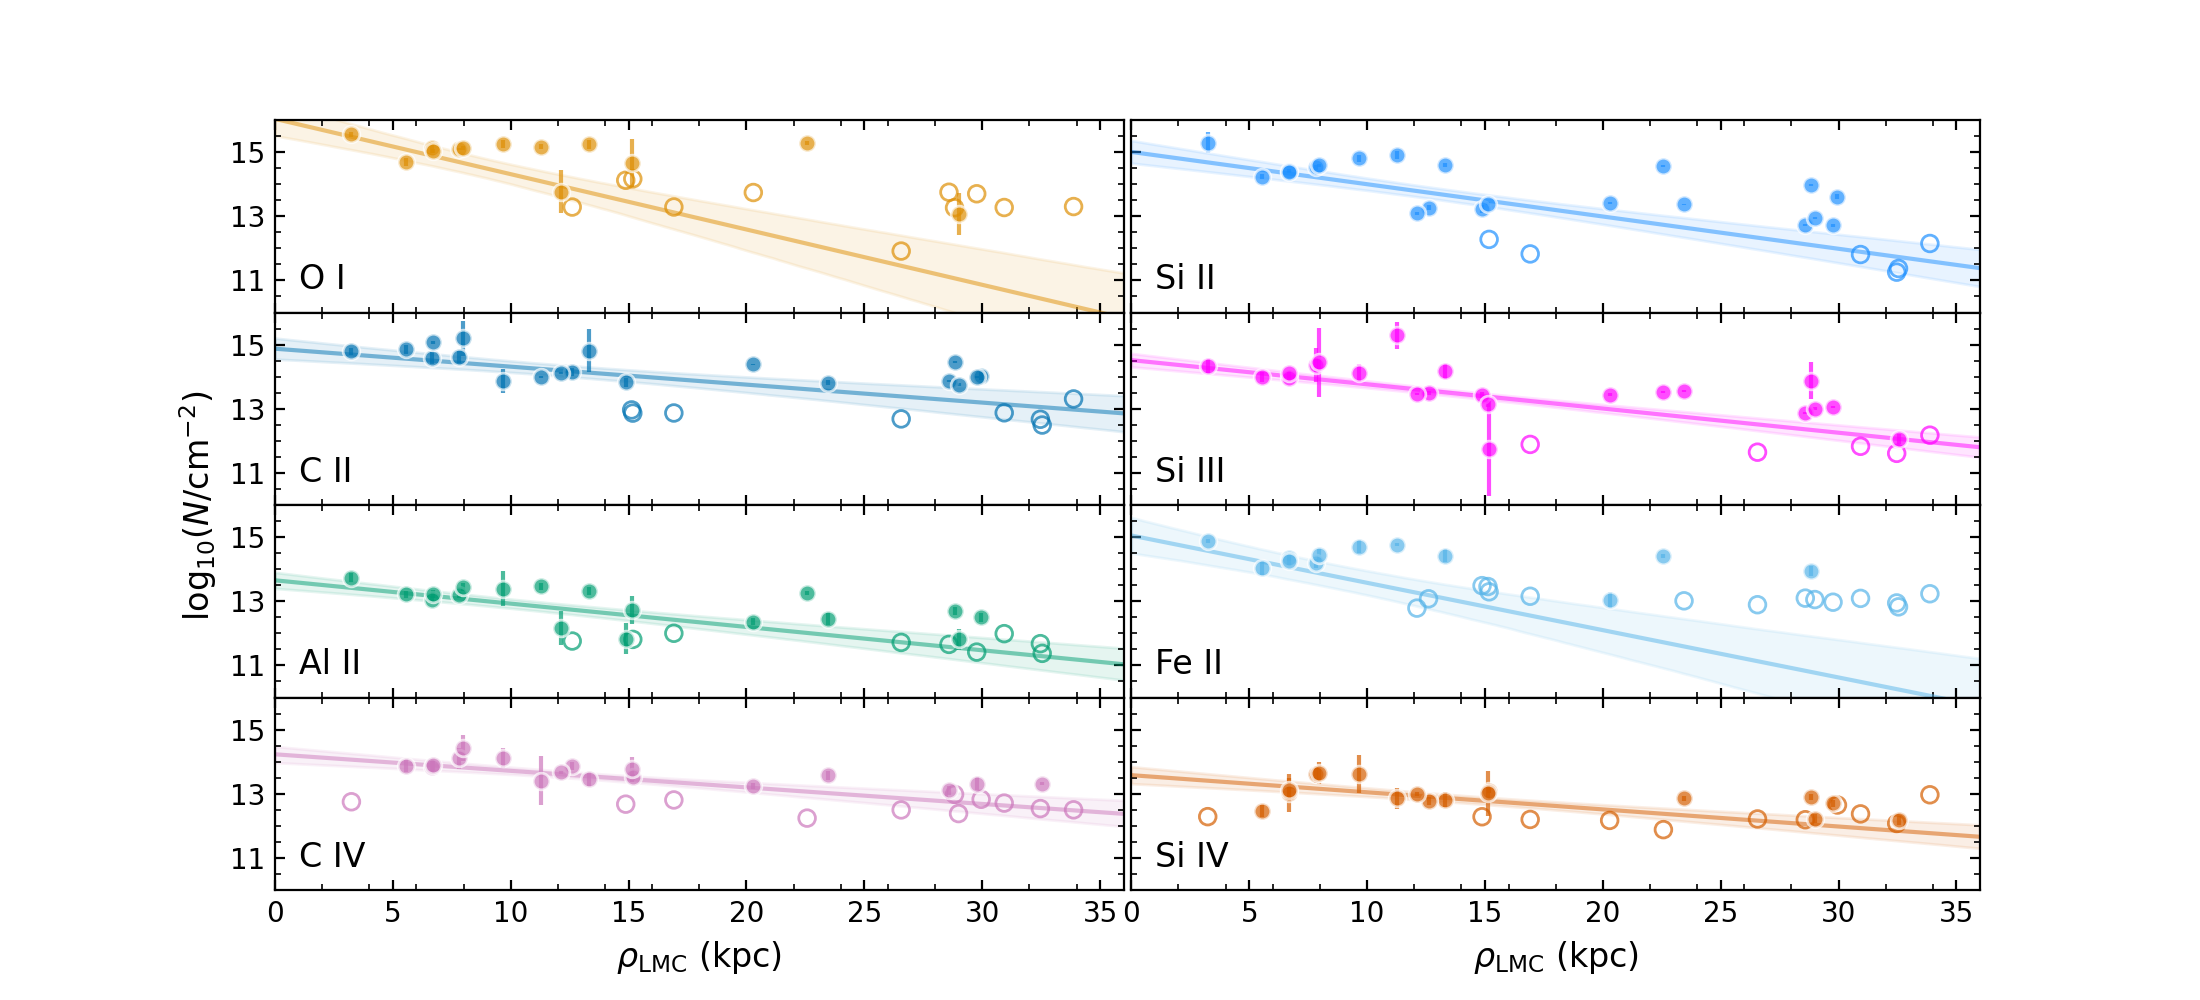

In [157]:
fig,axs = plt.subplots(4,2, figsize = (11,5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.0, wspace = 0.009)
for ax in axs.flatten():
    ax.tick_params(which = "both", direction = "in", top = True, right = True)
    ax.set_yticks([11,13,15], ["11", "13", "15"])
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
_ = ax.set_ylim(10,16)
_ = ax.set_xlim(0,36)

for ax in axs[-1,:]:
    ax.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
    
axs[2,0].set_ylabel(r"                  $\log_{10}(N/\mathrm{cm}^{-2})$", 
                    fontsize = 12)


#OI
ax = axs[0,0]

ax.errorbar(xOI[delta_OI], yOI[delta_OI], ysig_OI[delta_OI], 
            color = pal[1], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xOI[~delta_OI], yOI[~delta_OI], 
           facecolor = "none", edgecolor = pal[1], alpha = 0.7)
ax.plot(xx, mean_line_OI, color = pal[1], alpha = 0.5)
ax.fill_between(xx, lo_line_OI, hi_line_OI, color = pal[1], alpha = 0.1)

ax.text(1, 10.5, "O I", ha = "left", va = "bottom", fontsize = 12)


#SiII
ax = axs[0,1]

ax.errorbar(xSiII[delta_SiII], ySiII[delta_SiII], ysig_SiII[delta_SiII], 
            color = "dodgerblue", fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xSiII[~delta_SiII], ySiII[~delta_SiII], 
           facecolor = "none", edgecolor = "dodgerblue", alpha = 0.7)
ax.plot(xx, mean_line_SiII, color = "dodgerblue", alpha = 0.5)
ax.fill_between(xx, lo_line_SiII, hi_line_SiII, color = "dodgerblue", alpha = 0.1)

ax.text(1, 10.5, "Si II", ha = "left", va = "bottom", fontsize = 12)

#CII
ax = axs[1,0]

ax.errorbar(xCII[delta_CII], yCII[delta_CII], ysig_CII[delta_CII], 
            color = pal[0], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xCII[~delta_CII], yCII[~delta_CII], 
           facecolor = "none", edgecolor = pal[0], alpha = 0.7)
ax.plot(xx, mean_line_CII, color = pal[0], alpha = 0.5)
ax.fill_between(xx, lo_line_CII, hi_line_CII, color = pal[0], alpha = 0.1)

ax.text(1, 10.5, "C II", ha = "left", va = "bottom", fontsize = 12)

#SiIII
ax = axs[1,1]

ax.errorbar(xSiIII[delta_SiIII], ySiIII[delta_SiIII], ysig_SiIII[delta_SiIII], 
            color = "magenta", fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xSiIII[~delta_SiIII], ySiIII[~delta_SiIII], 
           facecolor = "none", edgecolor = "magenta", alpha = 0.7)
ax.plot(xx, mean_line_SiIII, color = "magenta", alpha = 0.5)
ax.fill_between(xx, lo_line_SiIII, hi_line_SiIII, color = "magenta", alpha = 0.1)

ax.text(1, 10.5, "Si III", ha = "left", va = "bottom", fontsize = 12)

#AlII
ax = axs[2,0]

ax.errorbar(xAlII[delta_AlII], yAlII[delta_AlII], ysig_AlII[delta_AlII], 
            color = pal[2], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xAlII[~delta_AlII], yAlII[~delta_AlII], 
           facecolor = "none", edgecolor = pal[2], alpha = 0.7)
ax.plot(xx, mean_line_AlII, color = pal[2], alpha = 0.5)
ax.fill_between(xx, lo_line_AlII, hi_line_AlII, color = pal[2], alpha = 0.1)

ax.text(1, 10.5, "Al II", ha = "left", va = "bottom", fontsize = 12)

#FeII
ax = axs[2,1]

ax.errorbar(xFeII[delta_FeII], yFeII[delta_FeII], ysig_FeII[delta_FeII], 
            color = pal[9], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xFeII[~delta_FeII], yFeII[~delta_FeII], 
           facecolor = "none", edgecolor = pal[9], alpha = 0.7)
ax.plot(xx, mean_line_FeII, color = pal[9], alpha = 0.5)
ax.fill_between(xx, lo_line_FeII, hi_line_FeII, color = pal[9], alpha = 0.1)

ax.text(1, 10.5, "Fe II", ha = "left", va = "bottom", fontsize = 12)

#CIV
ax = axs[3,0]

ax.errorbar(xCIV[delta_CIV], yCIV[delta_CIV], ysig_CIV[delta_CIV], 
            color = pal[4], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xCIV[~delta_CIV], yCIV[~delta_CIV], 
           facecolor = "none", edgecolor = pal[4], alpha = 0.7)
ax.plot(xx, mean_line_CIV, color = pal[4], alpha = 0.5)
ax.fill_between(xx, lo_line_CIV, hi_line_CIV, color = pal[4], alpha = 0.1)

ax.text(1, 10.5, "C IV", ha = "left", va = "bottom", fontsize = 12)

#SiIV
ax = axs[3,1]

ax.errorbar(xSiIV[delta_SiIV], ySiIV[delta_SiIV], ysig_SiIV[delta_SiIV], 
            color = pal[3], fmt = "o", alpha = 0.7, markeredgecolor = "w")
ax.scatter(xSiIV[~delta_SiIV], ySiIV[~delta_SiIV], 
           facecolor = "none", edgecolor = pal[3], alpha = 0.7)
ax.plot(xx, mean_line_SiIV, color = pal[3], alpha = 0.5)
ax.fill_between(xx, lo_line_SiIV, hi_line_SiIV, color = pal[3], alpha = 0.1)

ax.text(1, 10.5, "Si IV", ha = "left", va = "bottom", fontsize = 12)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure2.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure2.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


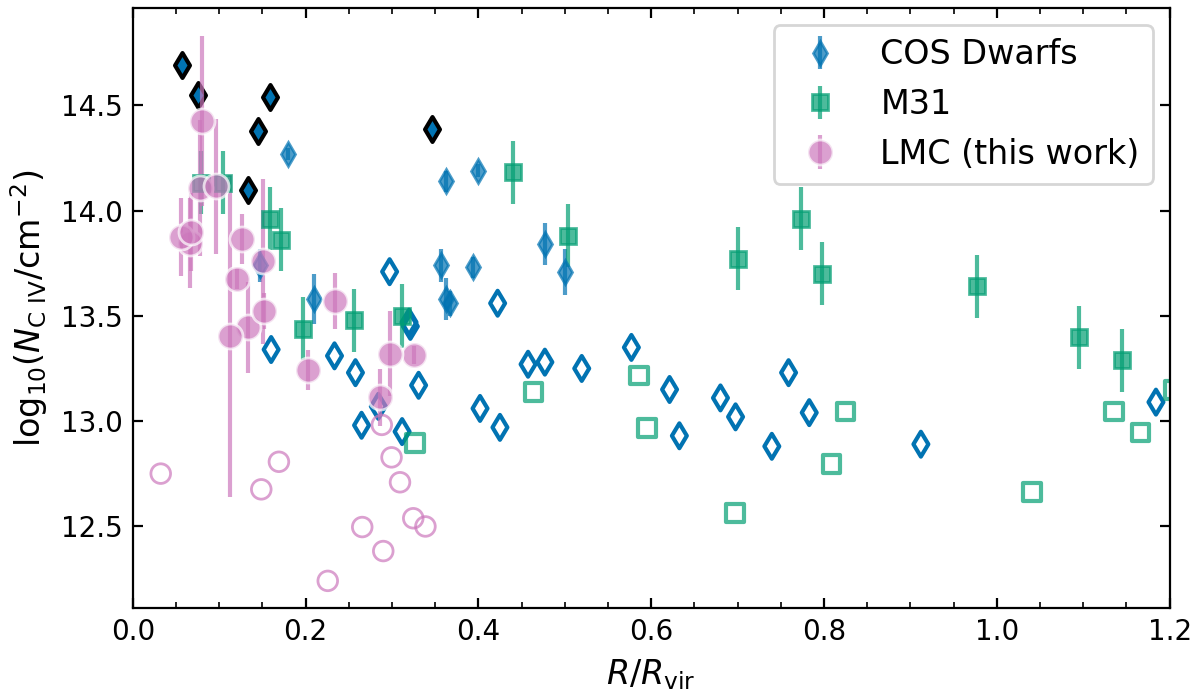

In [172]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (6,3.5))
ax.tick_params(which = "both", direction = "in", top = True, right = True)
# ax.set_yticks([11,13,15], ["11", "13", "15"])
ax.xaxis.set_minor_locator(MultipleLocator(.05))
# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
# _ = ax.set_ylim(10,16)
# _ = ax.set_xlim(0,0.66)
ax.set_xlabel(r"$R/R_\mathrm{vir}$", fontsize = 12)
    
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C~IV}/\mathrm{cm}^{-2})$", 
                    fontsize = 12)







cd_detect = cd_NCIV_err > 0
cd_ul = (cd_NCIV_err < 0) & (cd_NCIV_err > -2)
cd_ll = cd_NCIV_err < -2
ax.errorbar(cd_R_Rvir[cd_detect], cd_NCIV[cd_detect], cd_NCIV_err[cd_detect], color = pal[0], 
           fmt = "d", alpha = 0.7, label = "COS Dwarfs")
ax.scatter(cd_R_Rvir[cd_ul], cd_NCIV[cd_ul], facecolor = "none", marker = "d", 
           edgecolor = pal[0], s = 40, lw = 1.5)
ax.scatter(cd_R_Rvir[cd_ll], cd_NCIV[cd_ll], facecolor = pal[0], marker = "d", 
           edgecolor = "k", s = 40, lw = 1.5)


ax.errorbar(am_R_vir, am_NCIV, 0.15, color = pal[2], fmt = "s", alpha = 0.7, label = "M31")
ax.scatter(am_R_vir_ul, am_NCIV_ul, facecolor = "none", edgecolor = pal[2], 
           alpha = 0.7, s = 40, lw = 1.5, marker = "s")


ax.errorbar(xCIV[delta_CIV]/100., yCIV[delta_CIV], ysig_CIV[delta_CIV], 
            color = pal[4], fmt = "o", alpha = 0.7, markeredgecolor = "w", 
            label = "LMC (this work)", markersize = 9)
ax.scatter(xCIV[~delta_CIV]/100., yCIV[~delta_CIV], 
           facecolor = "none", edgecolor = pal[4], alpha = 0.7, s = 50)
# ax.plot(xx/100., mean_line_CIV, color = pal[4], alpha = 0.5)
# ax.fill_between(xx/100., lo_line_CIV, hi_line_CIV, color = pal[4], alpha = 0.1)



lg = ax.legend(fontsize = 12)

ax.set_xlim(0,1.2)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure5_lmc100.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure5_lmc100.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


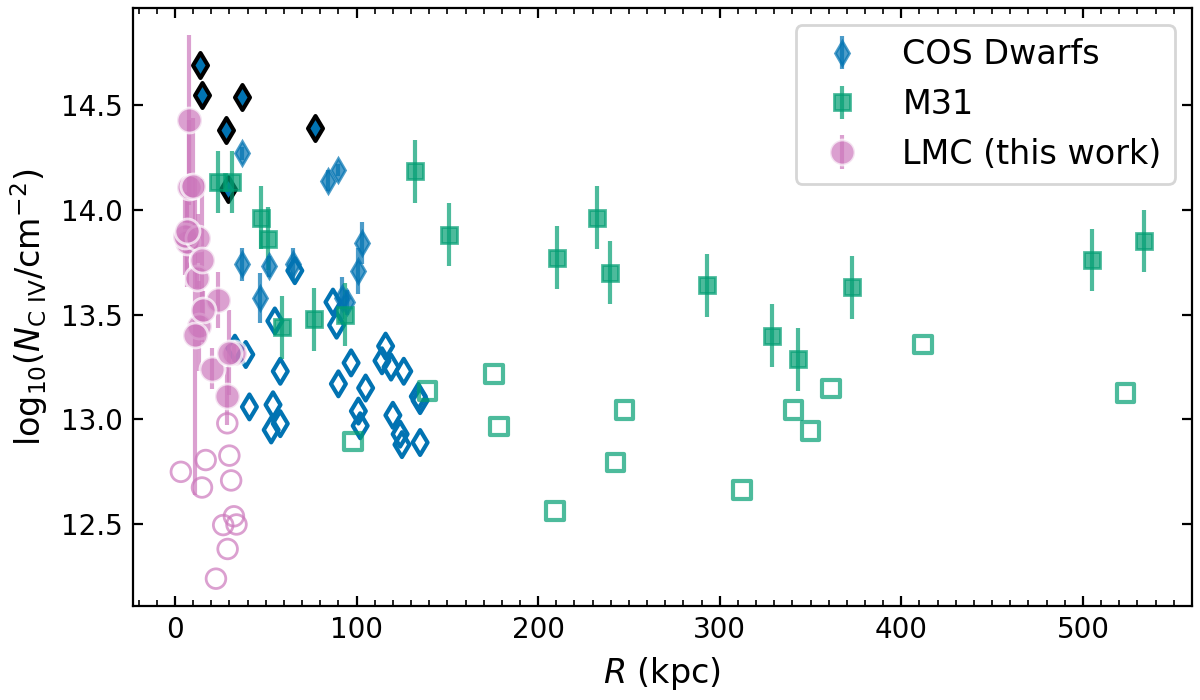

In [171]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (6,3.5))
ax.tick_params(which = "both", direction = "in", top = True, right = True)
# ax.set_yticks([11,13,15], ["11", "13", "15"])
ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
# _ = ax.set_ylim(10,16)
# _ = ax.set_xlim(0,0.66)
ax.set_xlabel(r"$R$ (kpc)", fontsize = 12)
    
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C~IV}/\mathrm{cm}^{-2})$", 
                    fontsize = 12)







cd_detect = cd_NCIV_err > 0
cd_ul = (cd_NCIV_err < 0) & (cd_NCIV_err > -2)
cd_ll = cd_NCIV_err < -2
ax.errorbar(cd_R[cd_detect], cd_NCIV[cd_detect], cd_NCIV_err[cd_detect], color = pal[0], 
           fmt = "d", alpha = 0.7, label = "COS Dwarfs")
ax.scatter(cd_R[cd_ul], cd_NCIV[cd_ul], facecolor = "none", marker = "d", 
           edgecolor = pal[0], s = 40, lw = 1.5)
ax.scatter(cd_R[cd_ll], cd_NCIV[cd_ll], facecolor = pal[0], marker = "d", 
           edgecolor = "k", s = 40, lw = 1.5)


ax.errorbar(am_R_phys, am_NCIV, 0.15, color = pal[2], fmt = "s", alpha = 0.7, label = "M31")
ax.scatter(am_R_phys_ul, am_NCIV_ul, facecolor = "none", edgecolor = pal[2], 
           alpha = 0.7, s = 40, lw = 1.5, marker = "s")


ax.errorbar(xCIV[delta_CIV], yCIV[delta_CIV], ysig_CIV[delta_CIV], 
            color = pal[4], fmt = "o", alpha = 0.7, markeredgecolor = "w", 
            label = "LMC (this work)", markersize = 9)
ax.scatter(xCIV[~delta_CIV], yCIV[~delta_CIV], 
           facecolor = "none", edgecolor = pal[4], alpha = 0.7, s = 50)
# ax.plot(xx/100., mean_line_CIV, color = pal[4], alpha = 0.5)
# ax.fill_between(xx/100., lo_line_CIV, hi_line_CIV, color = pal[4], alpha = 0.1)



lg = ax.legend(fontsize = 12)

# ax.set_xlim(0,1.2)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure5_vkpc.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure5_vkpc.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


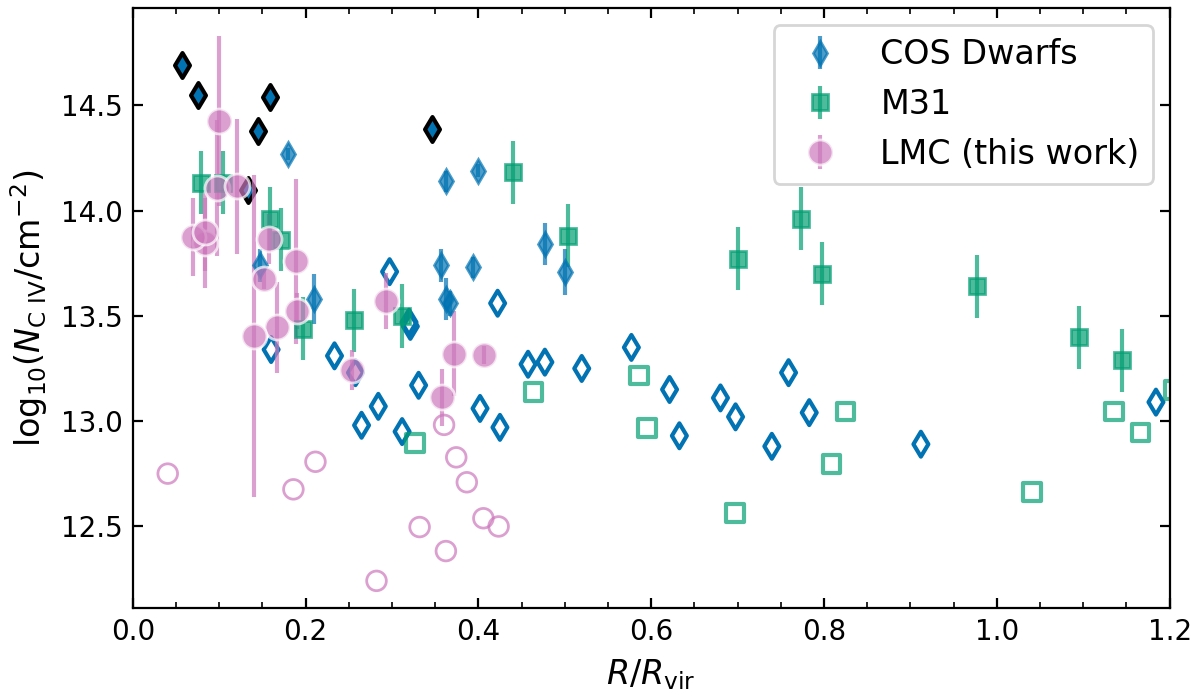

In [173]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (6,3.5))
ax.tick_params(which = "both", direction = "in", top = True, right = True)
# ax.set_yticks([11,13,15], ["11", "13", "15"])
ax.xaxis.set_minor_locator(MultipleLocator(.05))
# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
# _ = ax.set_ylim(10,16)
# _ = ax.set_xlim(0,0.66)
ax.set_xlabel(r"$R/R_\mathrm{vir}$", fontsize = 12)
    
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C~IV}/\mathrm{cm}^{-2})$", 
                    fontsize = 12)







cd_detect = cd_NCIV_err > 0
cd_ul = (cd_NCIV_err < 0) & (cd_NCIV_err > -2)
cd_ll = cd_NCIV_err < -2
ax.errorbar(cd_R_Rvir[cd_detect], cd_NCIV[cd_detect], cd_NCIV_err[cd_detect], color = pal[0], 
           fmt = "d", alpha = 0.7, label = "COS Dwarfs")
ax.scatter(cd_R_Rvir[cd_ul], cd_NCIV[cd_ul], facecolor = "none", marker = "d", 
           edgecolor = pal[0], s = 40, lw = 1.5)
ax.scatter(cd_R_Rvir[cd_ll], cd_NCIV[cd_ll], facecolor = pal[0], marker = "d", 
           edgecolor = "k", s = 40, lw = 1.5)


ax.errorbar(am_R_vir, am_NCIV, 0.15, color = pal[2], fmt = "s", alpha = 0.7, label = "M31")
ax.scatter(am_R_vir_ul, am_NCIV_ul, facecolor = "none", edgecolor = pal[2], 
           alpha = 0.7, s = 40, lw = 1.5, marker = "s")


ax.errorbar(xCIV[delta_CIV]/80., yCIV[delta_CIV], ysig_CIV[delta_CIV], 
            color = pal[4], fmt = "o", alpha = 0.7, markeredgecolor = "w", 
            label = "LMC (this work)", markersize = 9)
ax.scatter(xCIV[~delta_CIV]/80., yCIV[~delta_CIV], 
           facecolor = "none", edgecolor = pal[4], alpha = 0.7, s = 50)
# ax.plot(xx/100., mean_line_CIV, color = pal[4], alpha = 0.5)
# ax.fill_between(xx/100., lo_line_CIV, hi_line_CIV, color = pal[4], alpha = 0.1)



lg = ax.legend(fontsize = 12)

ax.set_xlim(0,1.2)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure5_lmc80.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure5_lmc80.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


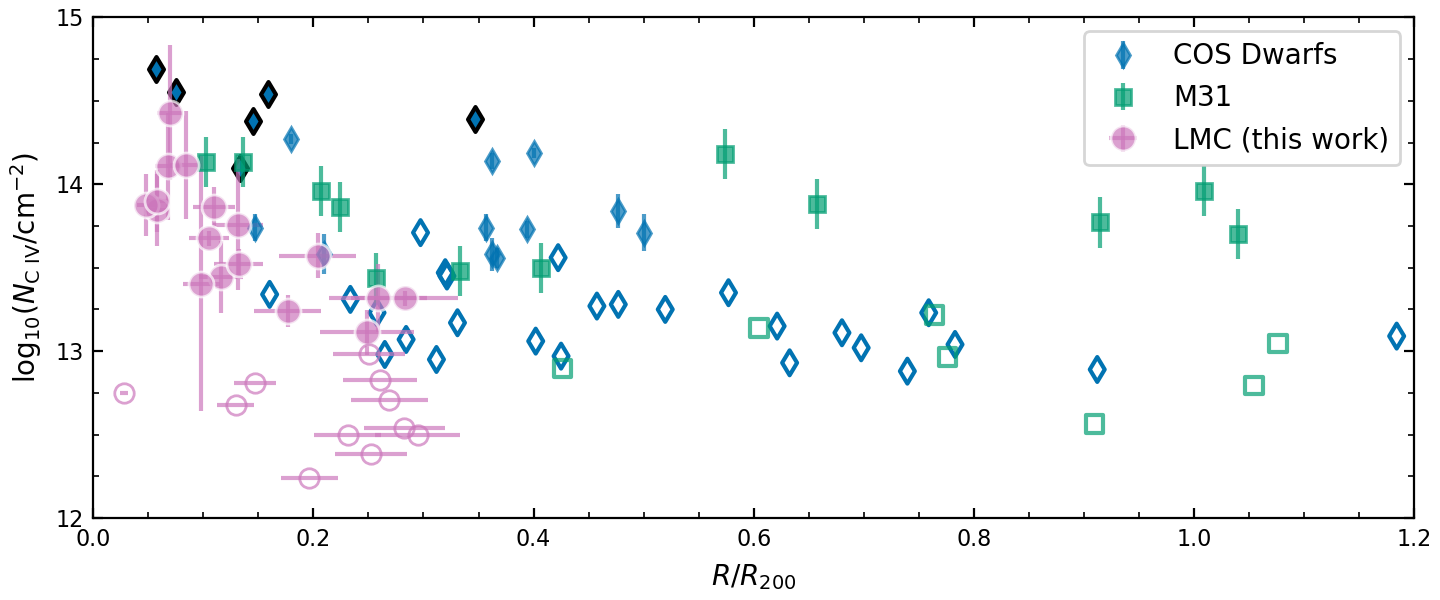

In [57]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (7.2,3))
ax.tick_params(which = "both", direction = "in", top = True, right = True)
ax.set_yticks([12,13,14,15], ["12", "13", "14", "15"])
ax.xaxis.set_minor_locator(MultipleLocator(.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
# _ = ax.set_ylim(10,16)
# _ = ax.set_xlim(0,0.66)
ax.set_xlabel(r"$R/R_\mathrm{200}$", fontsize = 10)
    
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C~IV}/\mathrm{cm}^{-2})$", 
                    fontsize = 10)







cd_detect = cd_NCIV_err > 0
cd_ul = (cd_NCIV_err < 0) & (cd_NCIV_err > -2)
cd_ll = cd_NCIV_err < -2
ax.errorbar(cd_R_Rvir[cd_detect], cd_NCIV[cd_detect], cd_NCIV_err[cd_detect], color = pal[0], 
           fmt = "d", alpha = 0.7, label = "COS Dwarfs")
ax.scatter(cd_R_Rvir[cd_ul], cd_NCIV[cd_ul], facecolor = "none", marker = "d", 
           edgecolor = pal[0], s = 40, lw = 1.5)
ax.scatter(cd_R_Rvir[cd_ll], cd_NCIV[cd_ll], facecolor = pal[0], marker = "d", 
           edgecolor = "k", s = 40, lw = 1.5)


ax.errorbar(am_R, am_NCIV, 0.15, color = pal[2], fmt = "s", alpha = 0.7, label = "M31")
ax.scatter(am_R_ul, am_NCIV_ul, facecolor = "none", edgecolor = pal[2], 
           alpha = 0.7, s = 40, lw = 1.5, marker = "s")


ax.errorbar(xCIV[delta_CIV]/115, yCIV[delta_CIV], ysig_CIV[delta_CIV], xerr = 15/115 * xCIV[delta_CIV]/87.5,
            color = pal[4], fmt = "o", alpha = 0.7, markeredgecolor = "w", 
            label = "LMC (this work)", markersize = 9)
ax.errorbar(xCIV[~delta_CIV]/115, yCIV[~delta_CIV], xerr = 15/115 * xCIV[~delta_CIV]/115, 
            fmt = "o", alpha = 0.7, markeredgecolor = pal[4], markersize = 7, color = "none", ecolor = pal[4])
# ax.scatter(xCIV[~delta_CIV]/87.5., yCIV[~delta_CIV], 
#            facecolor = "none", edgecolor = pal[4], alpha = 0.7, s = 50)
# ax.plot(xx/100., mean_line_CIV, color = pal[4], alpha = 0.5)
# ax.fill_between(xx/100., lo_line_CIV, hi_line_CIV, color = pal[4], alpha = 0.1)



lg = ax.legend(fontsize = 10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax.set_xlim(0,1.2)
ax.set_ylim(12,15)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure5_lmc_err.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure5_lmc_err.svg", 
            transparent = True)

In [21]:
ax.errorbar?

In [16]:
100-12.5

87.5

In [34]:
1.26e12 * 3/(4*np.pi*200*

300802842443.6822

In [39]:
rho_crit = 1.26e12/(230**3 * (200 * 4 * np.pi) / 3)

In [54]:
MM = 10**10.65

In [55]:
(3 * MM / (4 * np.pi * 200 * rho_crit))**(1/3)

75.55635311822648